# Imports    

In [77]:
try:
    import mne
except ModuleNotFoundError:    
    ! pip install mne[hdf5]
try:
    import autoreject
except ModuleNotFoundError:
    ! pip install autoreject

import mne
mne.set_log_level('error')  # reduce extraneous MNE output
import pandas as pd
import os

In [78]:
HOME = os.getcwd()
FILE1 = os.path.join(HOME, 'first.csv')
FILE2 = os.path.join(HOME, 'second.csv')

# converting data to MNE

In [79]:
# function to convert to our csv data to mne package
DEFAULT_BASELINE = (None, 5)
def csv_to_mne(df, sampling_rate=1000, montage_type:str=None, use_baseline=False, baseline=None, drop_last_n=None):
    if montage_type is None:
        montage_type = 'biosemi32'

    if baseline is None:
        baseline = DEFAULT_BASELINE
    # first set the montage
    montage = mne.channels.make_standard_montage(montage_type)
    # extract the names from the montage
    ch_names = list(montage.get_positions()["ch_pos"].keys())
    # we assume all electrodes are EEG
    types = ["eeg"] * 32
    # create a mne_info object to use with MNE data
    mne_info = mne.create_info(
        ch_names=ch_names, ch_types=types, sfreq=sampling_rate, verbose=False
    )
    
    # drop the last n sample if the 'drop_last_n' argument is set to a non-None value
    if isinstance(drop_last_n, int):
        df = df.iloc[:, :-drop_last_n]        

    data = mne.io.RawArray(df, mne_info, verbose=False)
    
    if use_baseline:
        data._data = mne.baseline.rescale(data._data, times=data.times, baseline=baseline)
    
    data.set_montage(montage)
    return data, ch_names 


In [80]:
# READ THE INITIAL DATA
df1 = pd.read_csv(FILE1, header=None)
df2 = pd.read_csv(FILE2, header=None)
# conver to mne data objects
mne1, ch_names= csv_to_mne(df1, use_baseline=True, drop_last_n=12)
mne2, ch_names= csv_to_mne(df2, use_baseline=True, drop_last_n=12)

mne1_org = mne1.copy()
mne2_org = mne2.copy()

# Filter and plot

In [81]:
from mne.filter import filter_data

def filter_mne(mne_data, low=1, high=40):
    return mne_data.copy().filter(l_freq=low, h_freq=high)

m1 = filter_mne(mne1)
m2 = filter_mne(mne2)

In [82]:
# we will do that through visualizing the filter mne data
import matplotlib.pyplot as plt
PLOTS = ['sensors', 'topomap', 'psd', 'general']

def plot_mne_data(mne_data, plot_types = None, show_names=False):
    if plot_types is None: 
        plot_types = PLOTS 

    data_psd = mne_data.compute_psd()
    if "sensors" in plot_types:
        mne_data.plot_sensors(show_names=show_names)
    if "general" in plot_types:
        mne_data.plot()
    if "topomap" in plot_types:
        data_psd.plot_topomap(show_names=show_names)
    if "psd" in plot_types:
        data_psd.plot(show_names=show_names)
    
    plt.show()

In [83]:
def plot_windows(mne_data, start=0, end=None, windows_size=0.5, picks=None):
    if picks is None:
        picks = 'all'

    if end is None:
        end = mne_data.times[-1]
    
    t = start
    counter = 1
    while t < end:
        
        copy = mne_data.copy()        
        # first extract the data in that specific windown
        data = copy.crop(tmin=t, tmax=min(t + windows_size, end), verbose=False)
        # compute psd and plot the topomap        
        data_psd = data.compute_psd()
        fig = data_psd.plot_topomap(show_names=True, show=False)        
        # set the figure's size
        fig.set_size_inches((16, 9))
 
        # set the title
        plt.title(f"{t} -- {min(t + windows_size, end)}")
 
        # save the plot
        plt.savefig(os.path.join(HOME, f'windows_n_{counter}'))
        # display the image
        plt.show()
        # # clear plt
        # plt.clf()

        # update the pointer
        t = min(t + windows_size, end)
        counter += 1

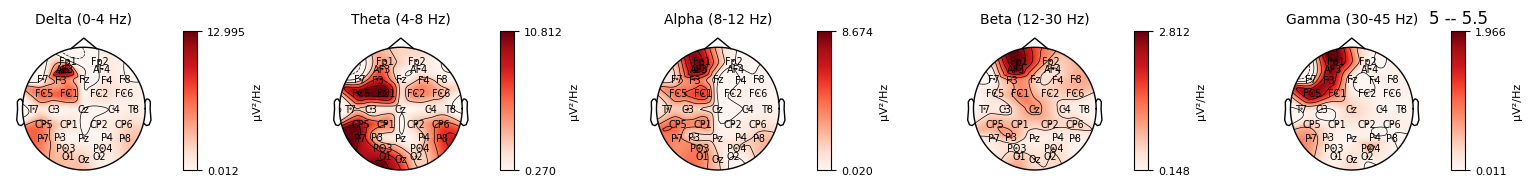

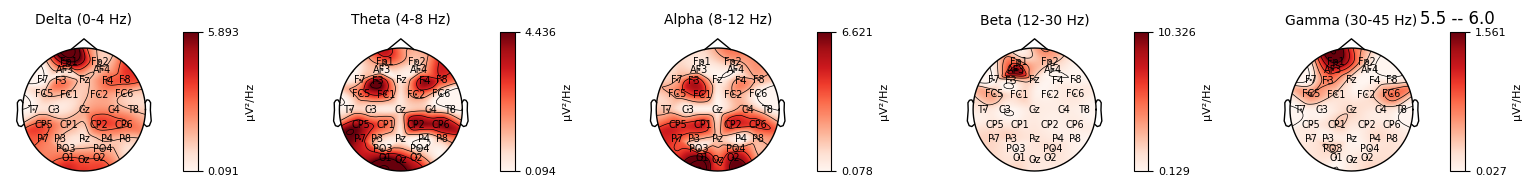

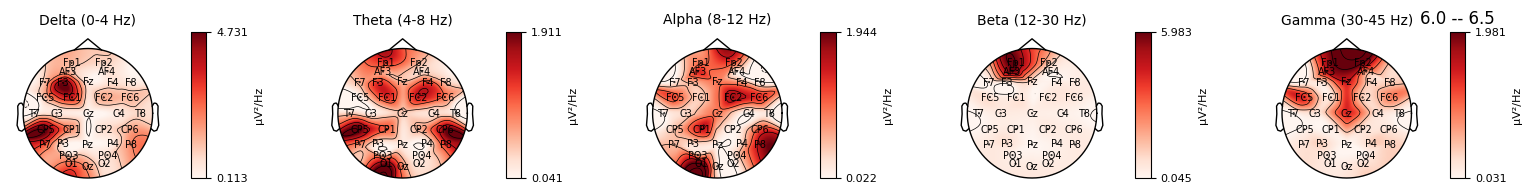

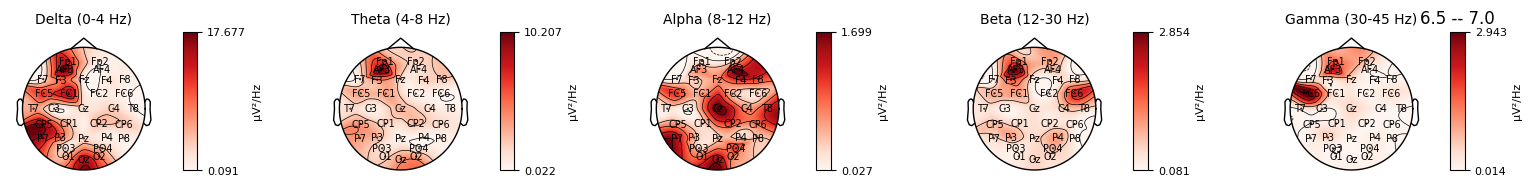

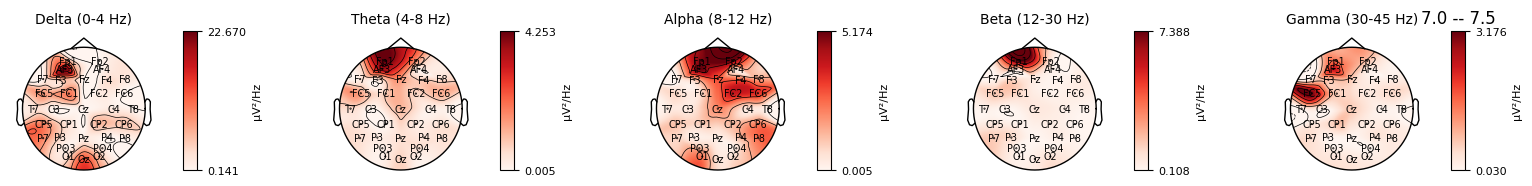

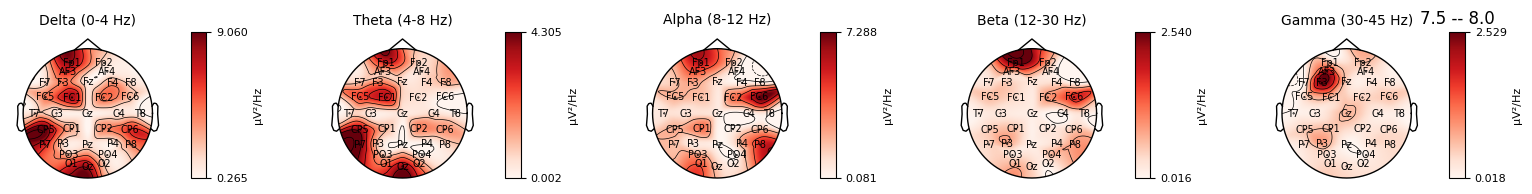

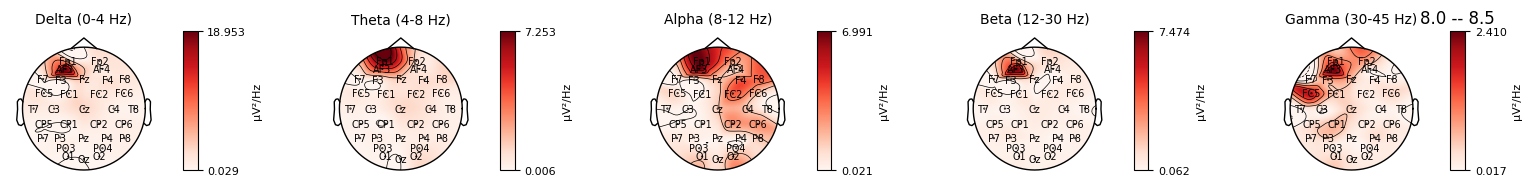

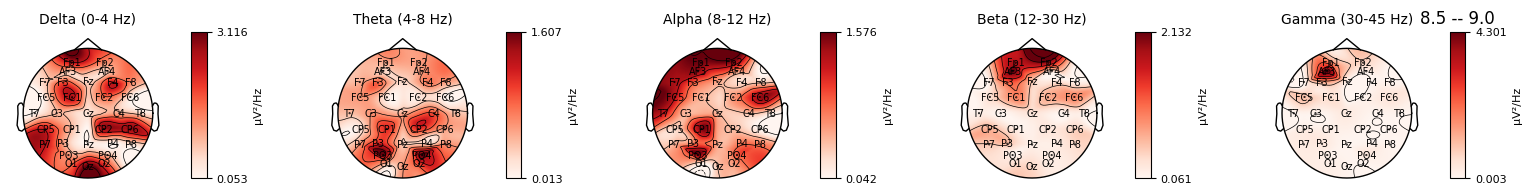

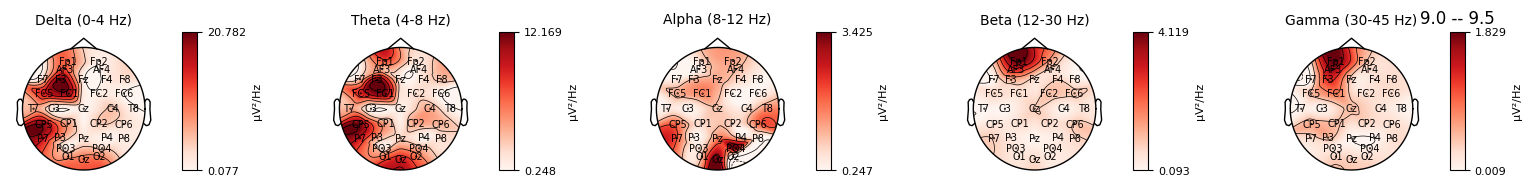

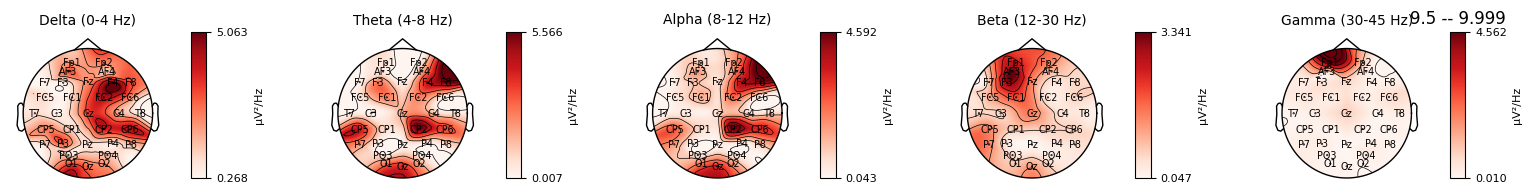

In [84]:
plot_windows(m1, start=5) # starting from the 5-th second (because the first 5 seconds are baseline)

# Identifying the channels with key activity
Visualizing the signals' intensities gives us a rough idea on the most significant / key channels. The active channels can be clusted into groups. Mainly:
1. Fp1, AF3
2. CP5, P7, P3
3. O1, Oz, O2

I decided not to consider any channels on the Motor Function Area as it is responsible for eye movement and orientation, according to: 
![image info](brain_view.png)

Let's consider some measurements to support the conclusions reached from the visualizations. The area under the curve might be a good quantitative measure of a channel activity as it reflects both variance and magnitude of the signal with slightly more desired properities:
1. Signals with extremely high or extremely low variance would have relatively smaller AUC
2. intensity of the signals play a major role in AUC as well.

In [86]:
import numpy as np

def auc(x: list[int], t: list[int]):
    assert len(x) == len(t)
    # first consider the differences between the timestamps
    t_copy = list(t).copy()
    t_copy.insert(0, 0)
    dts = np.ediff1d(t_copy)
    return sum(np.abs(np.multiply(x, dts)))

# extracting data after the first 5 seconds
m1_5 = mne1.copy().crop(tmin=5)
m2_5 = mne2.copy().crop(tmin=5)


areas = pd.Series(np.apply_along_axis(lambda x: auc(x, m1_5.times), 1, m1_5._data), index=ch_names)


# let's calculate the areas under the curve for

# areas = pd.Series(np.apply_along_axis(area_under_curve, 1, m1_5._data), index=ch_names)
areas.sort_values()

C3     0.000015
T8     0.000016
Pz     0.000017
F7     0.000019
P4     0.000020
T7     0.000020
PO3    0.000021
AF4    0.000023
C4     0.000024
PO4    0.000024
P8     0.000025
F8     0.000028
CP1    0.000028
O2     0.000028
Fz     0.000029
FC2    0.000030
O1     0.000030
FC6    0.000030
F4     0.000030
CP6    0.000031
CP2    0.000031
Cz     0.000031
P3     0.000031
Oz     0.000033
P7     0.000035
CP5    0.000036
Fp2    0.000037
FC1    0.000038
FC5    0.000040
F3     0.000041
Fp1    0.000059
AF3    0.000064
dtype: float64

Using The visualizations and the results of calculating the Area under the curve, we can conclude that AF1 and Fp1 are the channels representing the key activity of the brain.

In [57]:
channels_1 = ['AF3', 'Fp1']
def drop_channels(mne_data, channels_names: list[str]):
    # first create the corresponding object using the mne.pick_channels function
    wanted_channels = mne.pick_channels(mne_data.info['ch_names'], include=channels_names)
    print(wanted_channels) # indices of the channels to keep
    # use the wanted channels to create an info object for mne object creation
    info_object = mne.pick_info(mne_data.info, wanted_channels)
    # let's create the mne object
    new_data = mne_data._data[wanted_channels, :] # extract the channels: slice the rows, not the columns
    return mne.io.RawArray(new_data, info_object, verbose=False)

m1_new = drop_channels(m1_5, channels_1)


[0 1]


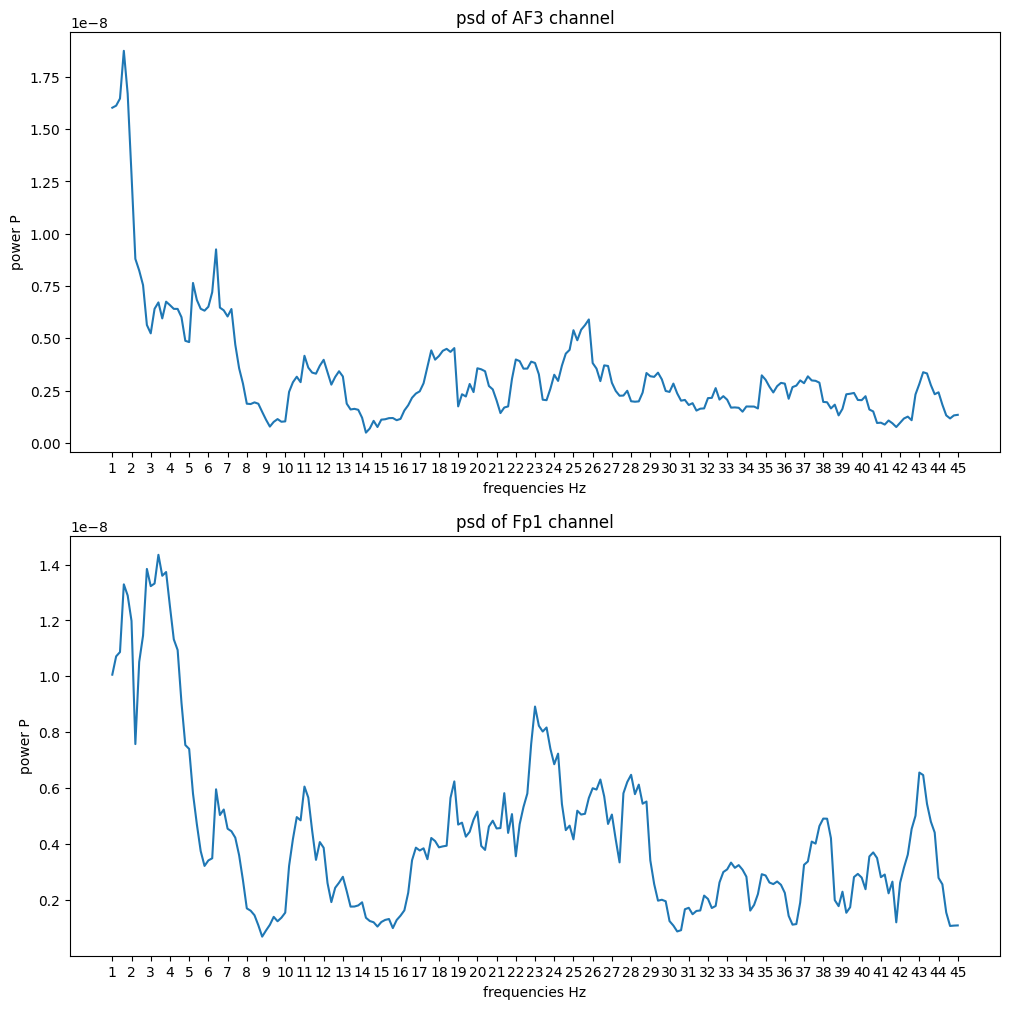

In [70]:
import numpy as np
def plot_psd(mne_data, ch_names, fmin=1, fmax=45, show=True):
    assert len(ch_names) == len(mne_data._data)
    # first calculate the power spectral density using the multitaper method
    psd, freqs = mne.time_frequency.psd_array_multitaper(mne_data._data, sfreq=mne_data.info['sfreq'], fmin=fmin, fmax=fmax, verbose=False)
    # let's calculate the mean over the channels
    # psd_over_channels = np.mean(psd, axis=0)
    # print(psd_over_channels.shape)
    
    if show: 
        figure , axis = plt.subplots(nrows= psd.shape[0], figsize=(12, 12))
        for index, ch_n in enumerate(ch_names):
            axis[index].plot(freqs, psd[index, :])
            axis[index].set_title(f"psd of {ch_n} channel")
            axis[index].set_xlabel('frequencies Hz')
            axis[index].set_ylabel('power P')
            axis[index].set_xticks(np.linspace(fmin, fmax, (fmax - fmin + 1)))

        plt.show()

    return psd, freqs

psd1, freqs1 = plot_psd(m1_new, channels_1)

visualizing the power distribution in the frequency domain, I can pick the key frequencies ranges

In [75]:
DELTA = [0, 4]
THETA = [4, 8]
ALPHA = [8, 12]
BETA = [12, 30]
GAMMA = [30, 45]
def frequecy_ranges(psd, freqs):
    assert len(psd) == len(freqs)
    ranges_ratio = dict(zip(['delta', 'theta', 'alpha', 'beta', 'gamma'], [[] for _ in range(5)]))
    for p, f in zip(psd, freqs):
        if DELTA[0] <= f <= DELTA[1]:
            ranges_ratio['delta'].append(p) 
        elif THETA[0] <= f <= THETA[1]:
            ranges_ratio['theta'].append(p)
        elif ALPHA[0] <= f <= ALPHA[1]:
            ranges_ratio['alpha'].append(p)
        elif BETA[0] <= f <= BETA[1]:
            ranges_ratio['beta'].append(p)
        else:
            ranges_ratio['gamma'].append(p)
    
    for freq_range, f in ranges_ratio.items():
        print(f'The range {freq_range}: {round(sum(f) / sum(psd) * 100, 3)} % of the total power')

for i, ch_n in enumerate(channels_1):
    print(f"For channel {ch_n}")
    frequecy_ranges(psd1[i], freqs1)
    print()

For channel AF3
The range delta: 22.343 % of the total power
The range theta: 15.861 % of the total power
The range alpha: 6.338 % of the total power
The range beta: 34.73 % of the total power
The range gamma: 20.728 % of the total power

For channel Fp1
The range delta: 20.623 % of the total power
The range theta: 11.495 % of the total power
The range alpha: 6.078 % of the total power
The range beta: 39.94 % of the total power
The range gamma: 21.864 % of the total power

